<a href="https://colab.research.google.com/github/simorxb/Neuromancer-Pendulum-Control/blob/main/Pendulum-Control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install (Colab only)**

Skip this step when running locally.

In [1]:
!pip install "neuromancer[examples] @ git+https://github.com/pnnl/neuromancer.git@master"

  Cloning https://github.com/pnnl/neuromancer.git (to revision master) to /tmp/pip-install-ix2pns8t/neuromancer_26249d365b134505823188ef7938f8a9
  Running command git clone --filter=blob:none --quiet https://github.com/pnnl/neuromancer.git /tmp/pip-install-ix2pns8t/neuromancer_26249d365b134505823188ef7938f8a9
  Resolved https://github.com/pnnl/neuromancer.git to commit 662ac066e5be80a8877894ed1ed6e46e7e0ad34d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.5/67.5 MB 8.9 MB/s eta 0:00:00
     ━━━━

In [10]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import argparse
from torch.utils.data import DataLoader
import os

from neuromancer.system import Node, System
from neuromancer.dynamics import integrators, ode
from neuromancer.dynamics.ode import ODESystem
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.loggers import BasicLogger
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.psl import plot
from neuromancer import psl
from neuromancer.modules import blocks
from neuromancer.modules.activations import activations

torch.manual_seed(0)

## System model - Pendulum

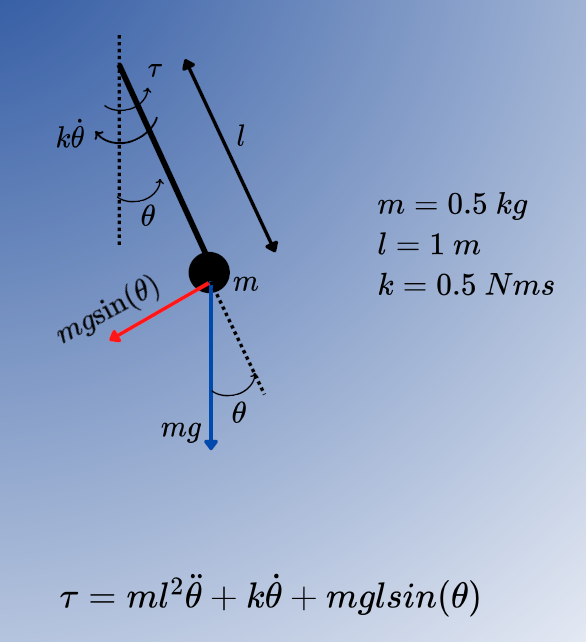

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Define a subclass of ODESystem to implement the pendulum equations - white box model
class Pendulum(ODESystem):

    def __init__(self, insize=3, outsize=2):
        """

        :param insize:
        :param outsize:
        """
        super().__init__(insize=insize, outsize=outsize)
        self.m = nn.Parameter(torch.tensor([0.5]), requires_grad=True) # Mass
        self.l = nn.Parameter(torch.tensor([1.0]), requires_grad=True) # Gravity
        self.k = nn.Parameter(torch.tensor([0.5]), requires_grad=True) # Damping coefficient

    def ode_equations(self, x, u):
        x1 = x[:, [0]] # theta
        x2 = x[:, [-1]] #theta_dot
        dx1 = x2
        dx2 = (u - self.k * x2 - self.m * 9.81 * self.l * torch.sin(x1))/(self.m * self.l**2)
        return torch.cat([dx1, dx2], dim=-1)




In [ ]:
ts = 0.1 # sample time
nx = 2 # number of states
nref = 1 # number of reference signals
nu = 1 # number of control inputs

umin = 0 # Minimum torque
umax = 7 # Maximum torque


# Create instance of Pendulum
pendulum = Pendulum()

# integrate continuous time ODE
integrator = integrators.RK4(pendulum, h=torch.tensor(ts))   # using 4th order runge kutta integrator
# symbolic system model
model = Node(integrator, ['x', 'u'], ['x'], name='model')

# neural net control policy with hard control action bounds
net = blocks.MLP_bounds(insize=nx + nref, outsize=nu, hsizes=[32, 32],
                    nonlin=activations['gelu'], min=umin, max=umax)
policy = Node(net, ['x', 'r'], ['u'], name='policy')

# closed-loop system model
cl_system = System([policy, model], nsteps=nsteps)
# cl_system.show()